In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from typing import NamedTuple, Tuple
import numpy.typing as npt
from tqdm import tqdm
import random

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

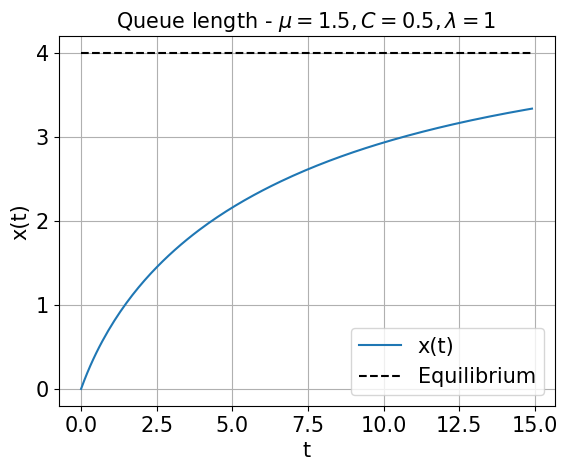

In [17]:
C = 1/2
MU = 1.5
LMBD = 1
NUM_POINTS = 150 
DELTA = 0.1 

class Parameters(NamedTuple):
    C: float
    MU: float
    LMBD: float
    
    @property
    def stationary_point(self) -> float: return LMBD / (C * (MU - LMBD))

def f(t, y, p: Parameters):
    """this is the rhs of the ODE to integrate, i.e. dy/dt=f(y,t)"""
    return -p.MU * p.C * y / (1 + p.C * y) + p.LMBD


def generate_data(x0: float, num_points: int, delta: float, parameters: Parameters) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    y0 = [x0]           # initial value y0=y(t0)
    t0 = 0             # integration limits for t: start at t0=0
    tf = 150 * delta   # and finish at tf=10
    t_eval = np.arange(t0, tf, delta)
    sol = solve_ivp(fun=lambda t,y: f(t, y, parameters), t_span=[t0, tf], y0=y0, t_eval=t_eval)  # computation of Solution 
    return sol.t, sol.y[0]

params = Parameters(C, MU, LMBD)
t, x = generate_data(0, NUM_POINTS, DELTA, params)

plt.plot(t, x, label='x(t)')
plt.plot(t, np.ones_like(t) * params.stationary_point, 'k--', label='Equilibrium')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Queue length - $\mu=' + str(MU) + f', C={C}, \\lambda={LMBD}$')
plt.show()

In [18]:
## Network definition
# Outputs x(t), parameters

class Network(nn.Module):
    def __init__(self, hidden_size: int = 16):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(1, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


100%|██████████| 3000/3000 [00:07<00:00, 404.90it/s]


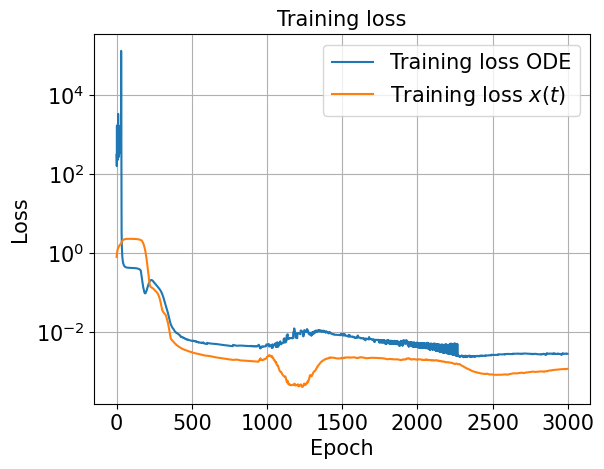

In [19]:
EPOCHS = 3000

trange = tqdm(range(EPOCHS))
network = Network()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

training_loss_x = []
training_loss_ode = []
x_training = torch.tensor(x[:, None], dtype=torch.float32)

for epoch in trange:
    ts = torch.tensor(np.array(range(NUM_POINTS)) * DELTA, requires_grad=True, dtype=torch.float32).reshape(-1,1)
    output = network(ts)

    X = output[:, [0]]
    estim_C = output[:, [1]]
    dXdT = torch.autograd.grad(output[:,0], ts, grad_outputs=torch.ones_like(output[:,0]), retain_graph=True)[0]

    optimizer.zero_grad()
    loss_x = nn.MSELoss()(X, x_training)
    loss_ode = nn.MSELoss()(dXdT, -MU * estim_C * X / (1 + estim_C * X) + LMBD)

    loss = loss_x + loss_ode
    loss.backward()
    optimizer.step()

    training_loss_x.append(loss_x.item())
    training_loss_ode.append(loss_ode.item())

plt.plot(range(EPOCHS), training_loss_ode, label='Training loss ODE')
plt.plot(range(EPOCHS), training_loss_x, label='Training loss $x(t)$')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.title('Training loss')
plt.legend()
plt.savefig('figures/pinn_training_estim_C.png')

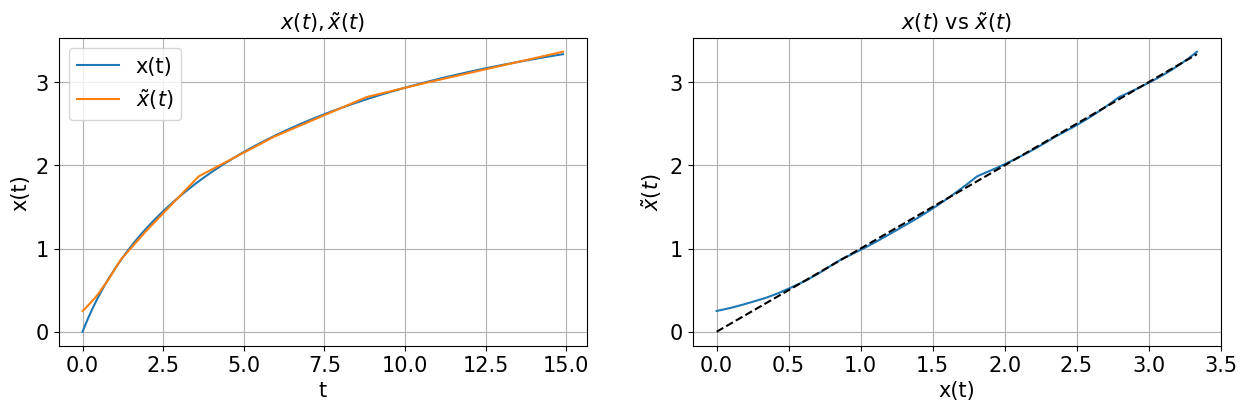

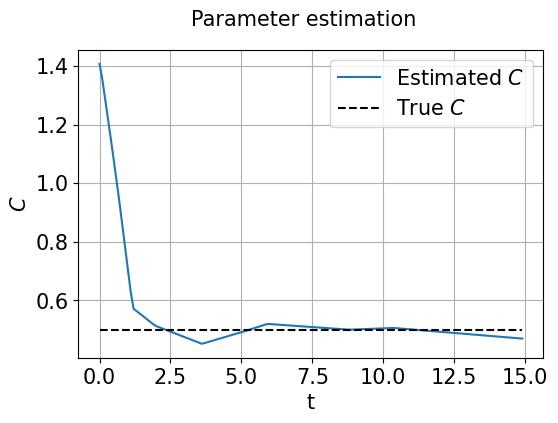

In [20]:
# Generate predicted trajectory and compare with true one

x_generated = []
estim_C = []

x_t = torch.tensor([0], dtype=torch.float32)
for step in np.array(range(NUM_POINTS)) * DELTA:
    x_t = torch.tensor([step], dtype=torch.float32)

    out = network(x_t)

    x_generated.append(out[0].item())
    estim_C.append(out[1].item())
    

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(t, x, label='x(t)')
ax[0].plot(t, x_generated, label=r'$\tilde{x}(t)$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x(t)')
ax[0].grid()
ax[0].legend()
ax[0].set_title(r'$x(t),\tilde{x}(t)$')


ax[1].plot(x, x_generated)
ax[1].set_xlabel('x(t)')
ax[1].set_ylabel(r'$\tilde{x} (t)$')
ax[1].plot(x, x, 'k--')
ax[1].grid()
ax[1].set_title(r'$x(t)$ vs $\tilde{x}(t)$')
plt.savefig('figures/pinn_trajectory_estim_C.png')

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(t, estim_C, label='Estimated $C$')
ax.plot(t, np.ones_like(t) * C, 'k--',  label='True $C$')
ax.grid()
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel(r'$C$')

plt.suptitle('Parameter estimation')

plt.savefig('figures/pinn_parameters_estim_C.png')